# Subsetting GEDI L4A Footprints

This tutorial will demonstrate how to subset [Global Ecosystem Dynamics Investigation (GEDI) L4A Footprint Level Aboveground Biomass Density (AGBD)](https://doi.org/10.3334/ORNLDAAC/2056) dataset to a study area of interest. GEDI L4A dataset is available for the period starting 2019-04-17 and covers latitudes of 52 North to 52 South. GEDI L4A data files are natively in HDF5 format, and each file represents one International Space Station (ISS) orbit. 

The [previous tutorial](1_gedi_l4a_search_download.ipynb) explains how to download GEDI L4A files for a study area of interest (bounding box or polygon) and a specific period. Once all the GEDI L4A files are downloaded, the global orbits of GEDI L4A can be clipped or subsetted to the study area of interest.

This tutorial requires the following Python modules installed in your system: `requests`, `numpy`, `h5py`, `datetime`, `pandas`, `geopandas`, `contextily`, `shapely`. Requirements are also in [requirements.txt](requirements.txt). To install the necessary Python modules, you can copy the requirements.txt from this repository and run:
```bash
pip install -r requirements.txt
```

In [106]:
%matplotlib inline
import requests
import h5py
import pandas as pd
import geopandas as gpd
import contextily as ctx
import h5py
import numpy as np
from glob import glob
from os import path
from shapely.geometry import MultiPolygon, Polygon
from shapely.ops import orient
import datetime as dt
import os

%config IPCompleter.greedy=True
import folium
import os
import requests
from tqdm import tqdm
from sentinelsat import SentinelAPI
import geopandas as gpd
import pandas as pd
import numpy as np
import csv
from shapely.geometry import Polygon
import fiona
from pyproj import Proj, CRS,transform
from datetime import datetime
import pygc
from io import StringIO
import shutil
import json
import pickle

import json
from tqdm import tqdm
import requests
import os
import rasterio as rio
from rasterio.mask import mask
from osgeo import gdal
import pickle
import numpy as np

import matplotlib.path as mpltPath

## 1. Polygonal Area of Interest

We will use the boundary of the [Great Smokey Mountain National Park (GRSM)](https://www.nps.gov/grsm/planyourvisit/maps.htm) to demonstrate the spatial subsetting process. The boundary file is in ESRI Shapefile format in the folder called `grsm` in the repository. Let's read the boundary file and print out its coordinate system.

In [107]:
main_datafile_path = "estingAustralia.csv"

In [108]:
treecoords = pd.read_csv(main_datafile_path)
treecoords

,Unnamed: 0,project,site,lat,long,Granule Number
0,0,SouthWestForests-DON019FireInv,k_1,-34.7310,116.2081,2
1,1,SouthWestForests-DON019FireInv,k_2,-34.7265,116.2081,2
2,2,SouthWestForests-DON019FireInv,k_3,-34.6949,116.2085,2
3,3,SouthWestForests-DON019FireInv,k_4,-34.7265,116.2136,1
4,4,SouthWestForests-DON019FireInv,k_5,-34.7221,116.2136,1
...,...,...,...,...,...,...
241,318,LIRE,k_242,-41.3530,147.5222,1
242,319,Ausplot Forest Monitoring Network,k_243,-41.3671,147.6032,3
243,320,LIPL,k_244,-42.4391,147.7789,3
244,321,LIPL,k_245,-42.7232,147.8451,5


In [109]:
sitelist = treecoords['site'][0:5]
lat = list(treecoords['lat'][0:5])
lon = list(treecoords['long'][0:5])
projectlist = list(treecoords["project"][0:5])

In [110]:
def latLonBoxByWandH(lat,lon,ew_width,ns_height):
    lats, lons = [], []
    #distance in m, az (in deg), lat (in deg), long (in deg)

    res = pygc.great_circle(distance=ew_width/2, azimuth=90, latitude=lat, longitude=lon)
    lat, lon = res['latitude'], res['longitude']

    res = pygc.great_circle(distance=ns_height/2, azimuth=180, latitude=lat, longitude=lon)
    lat, lon = res['latitude'], res['longitude']
    lats.append(lat), lons.append(lon)

    res = pygc.great_circle(distance=ew_width, azimuth=270, latitude=lat, longitude=lon)
    lat, lon = res['latitude'], res['longitude']
    lats.append(lat), lons.append(lon)

    res = pygc.great_circle(distance=ns_height, azimuth=0, latitude=lat, longitude=lon)
    lat, lon = res['latitude'], res['longitude']
    lats.append(lat), lons.append(lon)

    res = pygc.great_circle(distance=ew_width, azimuth=90, latitude=lat, longitude=lon)
    lat, lon = res['latitude'], res['longitude']
    lats.append(lat), lons.append(lon)
    
    return {'lats':lats,'lons':lons}

In [111]:
#lengths in m
ew_width = 250
ns_height = 250
size = int(ew_width/1000)

In [112]:
#loc_lon,loc_lat
loc_lat = np.asfarray(lat,float)
loc_lon = np.asfarray(lon,float)
len(loc_lat),len(loc_lon)

(5, 5)

In [113]:
polygons,footprint =[], []

for lat, lon, code in tqdm(zip(loc_lat,loc_lon, sitelist), total = len(loc_lat)):

    box = latLonBoxByWandH(lat,lon,ew_width,ns_height)
    
    polygon_geom = Polygon(zip(box['lons'], box['lats']))
    footprint.append(polygon_geom)
    crs = CRS('epsg:4326')
    polygon = gpd.GeoDataFrame(index=[0], crs=crs, geometry=[polygon_geom])  

    polygons.append(polygon)

100%|██████████| 5/5 [00:00<00:00, 380.82it/s]


In [114]:
polygons[0].crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [115]:
Proj("epsg:4326")

m = folium.Map([loc_lat[0],loc_lon[0]], zoom_start=12,tiles = "https://{s}.basemaps.cartocdn.com/dark_nolabels/{z}/{x}/{y}.png",
attr = '&copy; <a href="https://www.openstreetmap.org/copyright">OpenStreetMap</a> contributors &copy; <a href="https://carto.com/attributions">CARTO</a>')
for polygon in polygons:
    folium.GeoJson(polygon).add_to(m)
    
m

## 2. Searching and Downloading GEDI L4A Files
We will search for all the GEDI L4A files with the orbits passing over the GRSM boundary using the NASA Earthdata Common Metadata Repository (CMR) API. Please refer to the [previous tutorial](1_gedi_l4a_search_download.ipynb) for more details.

In [116]:
start_date = dt.datetime(2022, 1, 1) # specify your own start date
end_date = dt.datetime(2022, 6, 1)  # specify your end start date

In [117]:
polygons

[                                            geometry
 0  POLYGON ((116.20946 -34.73213, 116.20674 -34.7...,
                                             geometry
 0  POLYGON ((116.20946 -34.72763, 116.20674 -34.7...,
                                             geometry
 0  POLYGON ((116.20986 -34.69603, 116.20714 -34.6...,
                                             geometry
 0  POLYGON ((116.21496 -34.72763, 116.21224 -34.7...,
                                             geometry
 0  POLYGON ((116.21496 -34.72323, 116.21224 -34.7...]

In [118]:
testpoly = polygons[0:1]
testpoly

[                                            geometry
 0  POLYGON ((116.20946 -34.73213, 116.20674 -34.7...]

In [42]:
for grsm_poly in testpoly:
    # CMR formatted start and end times
    dt_format = '%Y-%m-%dT%H:%M:%SZ'
    temporal_str = start_date.strftime(dt_format) + ',' + end_date.strftime(dt_format)
        
    # converting to WGS84 coordinate system
    grsm_epsg4326 = grsm_poly.to_crs(epsg=4326)

    # orienting coordinates clockwise
    grsm_epsg4326.geometry = grsm_epsg4326.geometry.apply(orient, args=(1,))

    # reducing number of vertices in the polygon
    # CMR has 1000000 bytes limit
    # grsm_epsg4326 = grsm_epsg4326.simplify(0.0005)

    doi = '10.3334/ORNLDAAC/2056'# GEDI L4A DOI 

    # CMR API base url
    cmrurl='https://cmr.earthdata.nasa.gov/search/' 

    doisearch = cmrurl + 'collections.json?doi=' + doi
    concept_id = requests.get(doisearch).json()['feed']['entry'][0]['id']

    geojson = {"shapefile": ("grsm.json", grsm_epsg4326.geometry.to_json(), "application/geo+json")}

    page_num = 1
    page_size = 2000 # CMR page size limit

    granule_arr = []

    while True:
        
        # defining parameters
        cmr_param = {
            "collection_concept_id": concept_id, 
            "page_size": page_size,
            "page_num": page_num,
            "temporal": temporal_str,
            "simplify-shapefile": 'true' # this is needed to bypass 5000 coordinates limit of CMR
        }
        
        granulesearch = cmrurl + 'granules.json'
        response = requests.post(granulesearch, data=cmr_param, files=geojson)
        granules = response.json()['feed']['entry']
        
        if granules:
            for g in granules:
                granule_url = ''
                granule_poly = ''
                
                # read file size
                granule_size = float(g['granule_size'])
                
                # reading bounding geometries
                if 'polygons' in g:
                    polygonlis= g['polygons']
                    multipolygons = []
                    for poly in polygonlis:
                        i=iter(poly[0].split(" "))
                        ltln = list(map(" ".join,zip(i,i)))
                        multipolygons.append(Polygon([[float(p.split(" ")[1]), float(p.split(" ")[0])] for p in ltln]))
                    granule_poly = MultiPolygon(multipolygons)
                
                # Get URL of HDF5 files
                for links in g['links']:
                    if 'title' in links and links['title'].startswith('Download') \
                    and links['title'].endswith('.h5'):
                        granule_url = links['href']
                granule_arr.append([granule_url, granule_size, granule_poly])
                
            page_num += 1
        else: 
            break

    # adding bound as the last row into the dataframe
    # we will use this later in the plot
    granule_arr.append(['GRSM', 0, grsm_epsg4326.geometry.item() ]) 

    # creating a pandas dataframe
    l4adf = pd.DataFrame(granule_arr, columns=["granule_url", "granule_size", "granule_poly"])

    # Drop granules with empty geometry
    l4adf = l4adf[l4adf['granule_poly'] != '']

    print ("Total granules found: ", len(l4adf.index)-1)
    print ("Total file size (MB): ", l4adf['granule_size'].sum())

Total granules found:  2
Total file size (MB):  145.084322


There are 172 GEDI L4A files with total size of ~54 GB overlapping the GRSM area. Let's plot the bounding geometries of the first few files.

In [45]:
grsm_epsg3857['geometry']

0    POLYGON ((12936378.451 -4127537.566, 12936074....
Name: geometry, dtype: geometry

In [120]:
gdf_epsg3857[:3]

,granule_url,granule_size,granule_poly,geometry
0,https://data.ornldaac.earthdata.nasa.gov/prote...,70.461031,"MULTIPOLYGON (((99.4467392 -18.0969849, 101.87...","MULTIPOLYGON (((11070360.369 -2048903.585, 113..."
1,https://data.ornldaac.earthdata.nasa.gov/prote...,74.623291,"MULTIPOLYGON (((99.4202042 -17.9872837, 101.84...","MULTIPOLYGON (((11067406.506 -2036060.178, 113..."
2,GRSM,0.000000,POLYGON ((116.2094648387207 -34.73212677152698...,"POLYGON ((12936378.451 -4127537.566, 12936378...."


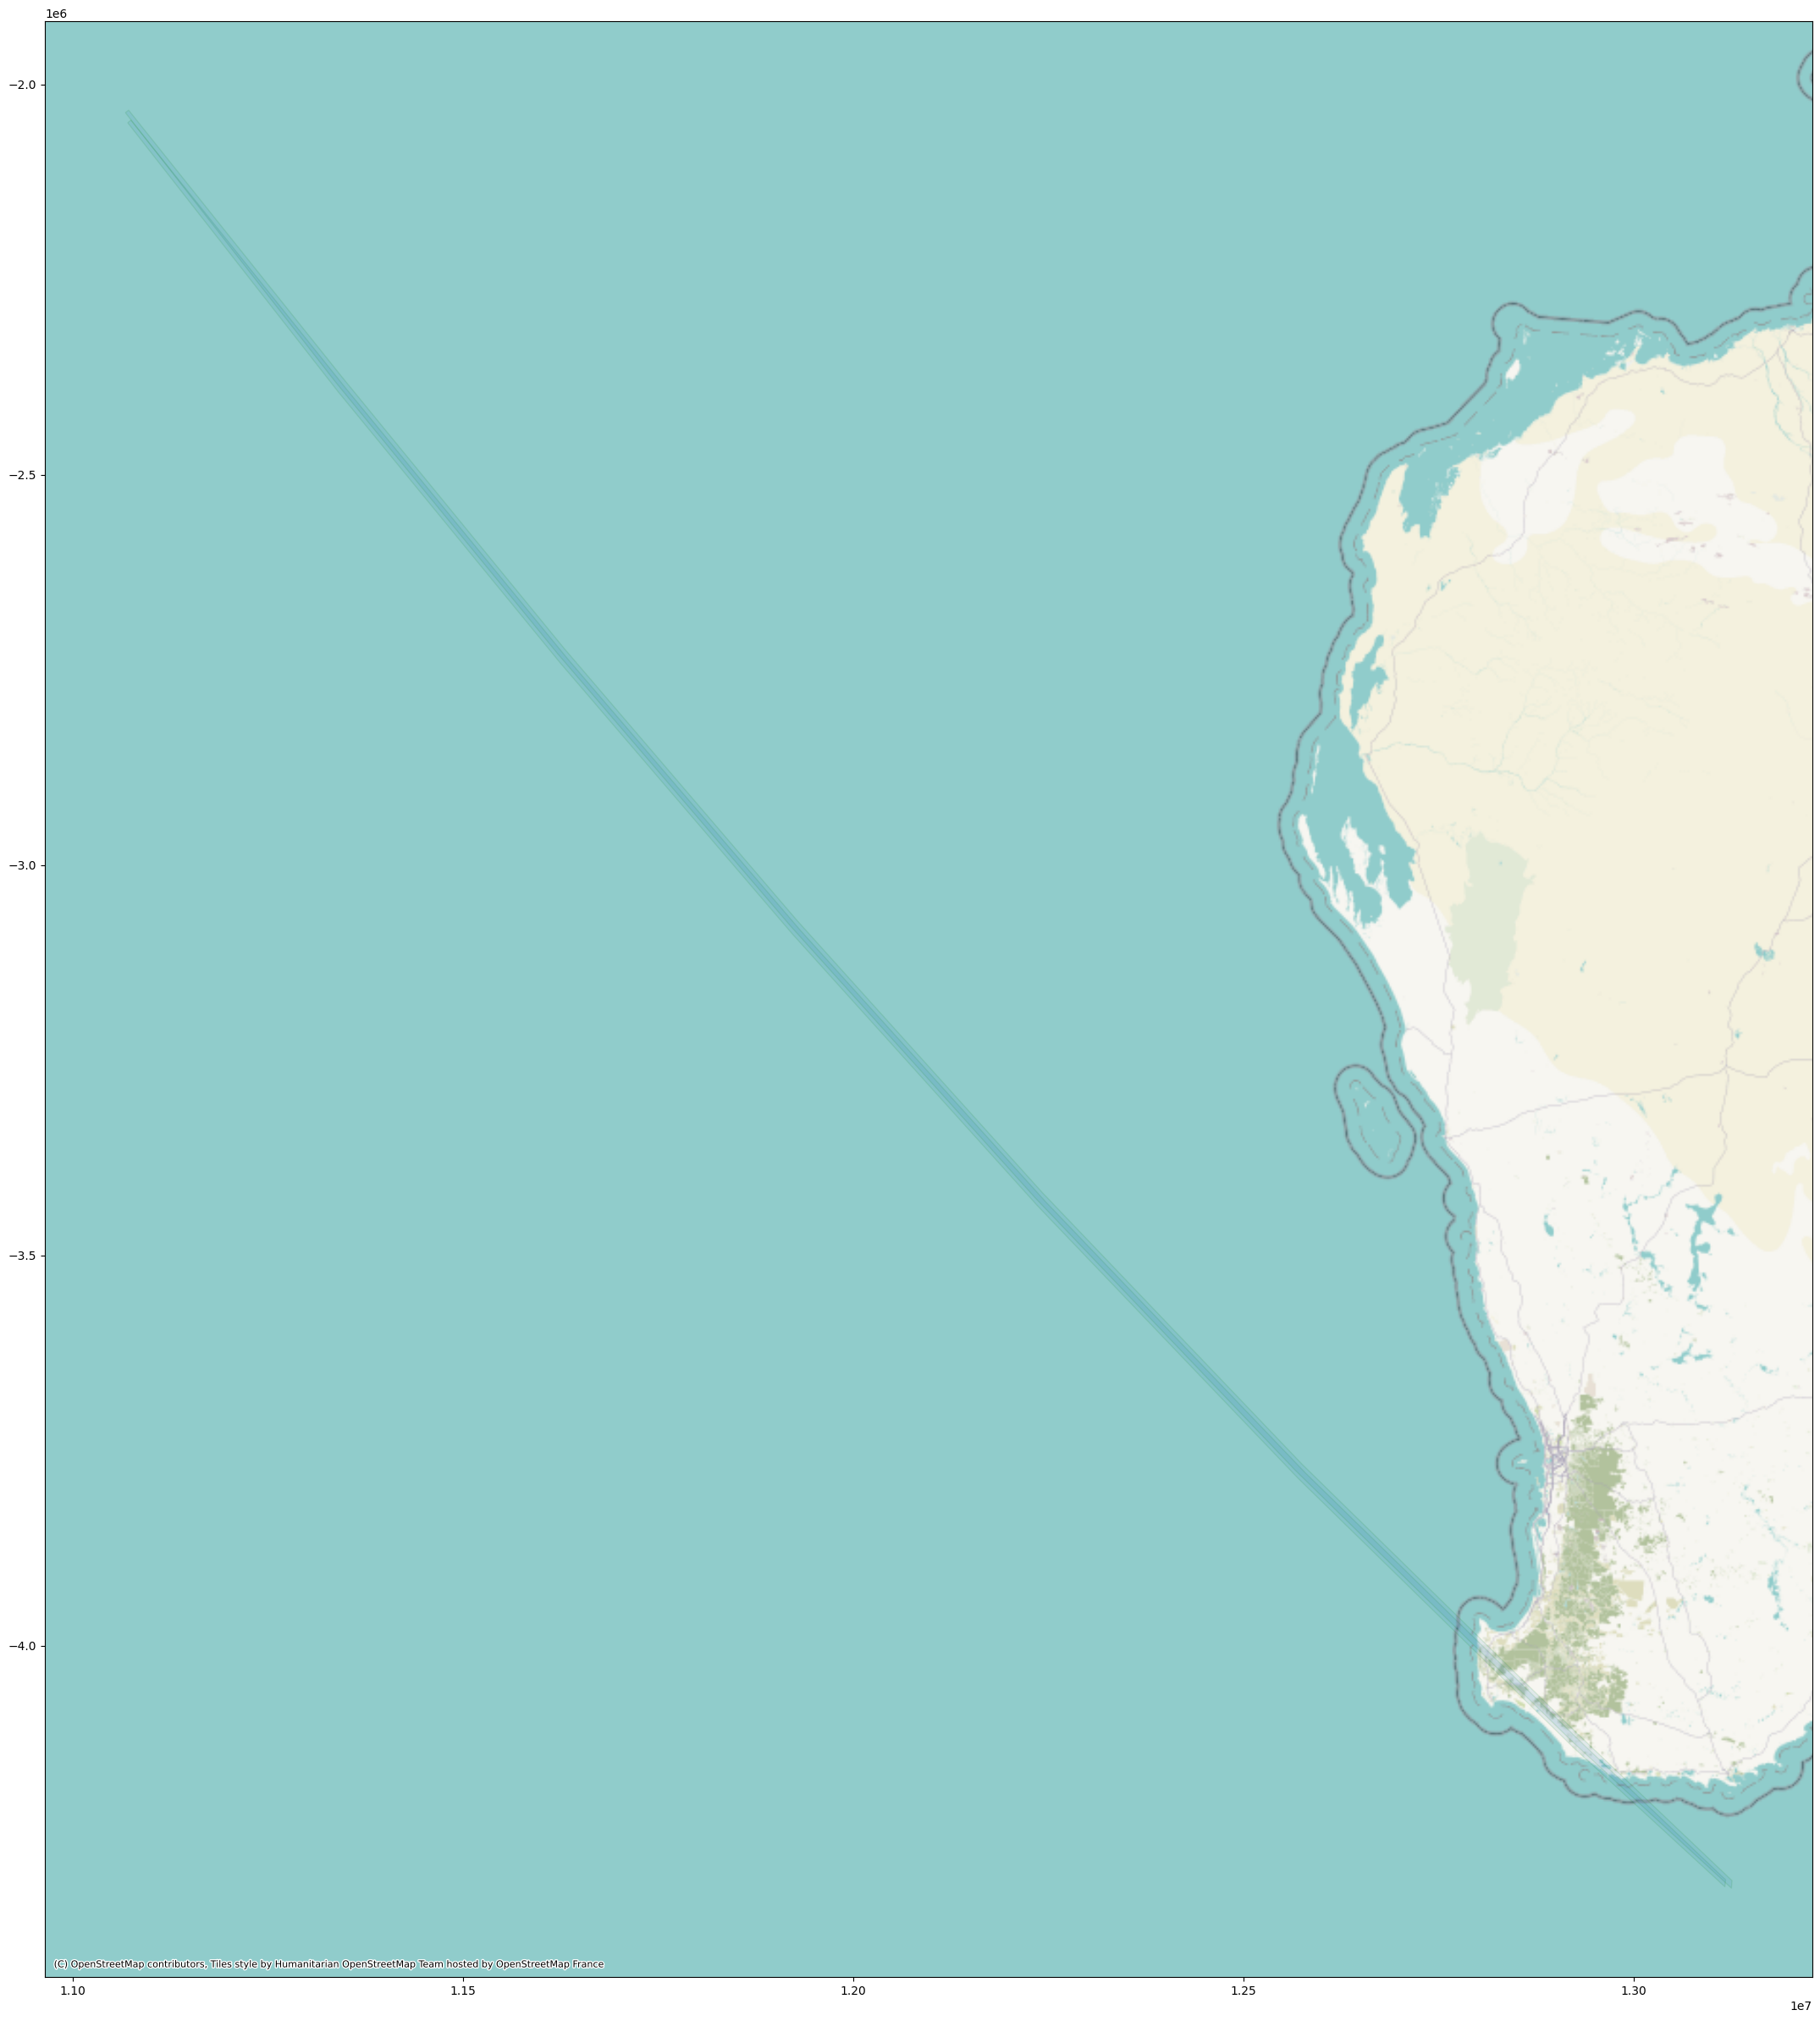

In [46]:
gdf = gpd.GeoDataFrame(l4adf, geometry=l4adf.granule_poly)
gdf.crs = "EPSG:4326"
gdf_epsg3857 = gdf.to_crs(epsg=3857)
ax=gdf_epsg3857[:3].plot(figsize=(60,30),edgecolor='green', alpha=0.1)
grsm_epsg3857['geometry'].plot(ax=ax, color = 'red')

ctx.add_basemap(ax)

Each GEDI L4A file extends beyond the study area of interest. Now, let's plot a zoomed-in version of the above map over GRSM.

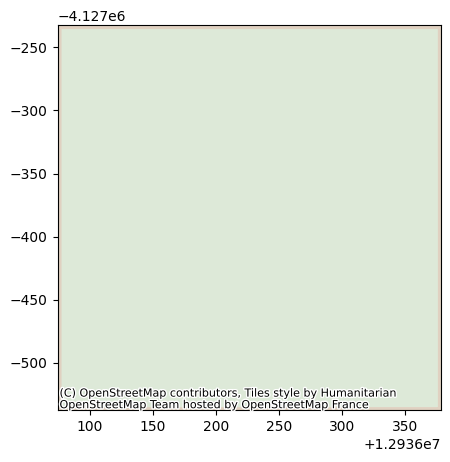

In [47]:
grsm_epsg3857 = polygons[0].to_crs(epsg=3857)
ax2=grsm_epsg3857['geometry'].plot(figsize=(10, 5), alpha=0.1, color='green', edgecolor='red', linewidth=5)
minx, miny, maxx, maxy = grsm_epsg3857.total_bounds
ax2.set_xlim(minx, maxx)
ax2.set_ylim(miny, maxy)
ctx.add_basemap(ax2)

As we see in the figures above, GEDI has a good coverage over the GRSM area. 

## 3. Downloading the GEDI L4A files

We will now save the granule URLS into a file `granules.txt` and use `wget` command in the terminal to download all the 136 files. Please refer to the [previous tutorial](1_gedi_l4a_search_download.ipynb) for more details on downloading programmatically.

In [122]:
# drop duplicate URLs if any
l4a_granules = l4adf[:-1].drop_duplicates(subset=['granule_url'])
l4a_granules.to_csv('granules.txt', columns = ['granule_url'], index=False, header = False)

In [49]:
!wget.exe --load-cookies .urs_cookies --save-cookies .urs_cookies --keep-session-cookies -P /gedi_data  -nc --content-disposition --trust-server-names -i granules.txt

--2023-10-29 10:31:58--  https://data.ornldaac.earthdata.nasa.gov/protected/gedi/GEDI_L4A_AGB_Density_V2_1/data/GEDI04_A_2022015220635_O17525_04_T06150_02_002_02_V002.h5
Resolving data.ornldaac.earthdata.nasa.gov (data.ornldaac.earthdata.nasa.gov)... 13.227.74.65, 13.227.74.82, 13.227.74.13, ...
Connecting to data.ornldaac.earthdata.nasa.gov (data.ornldaac.earthdata.nasa.gov)|13.227.74.65|:443... connected.
HTTP request sent, awaiting response... 303 See Other
--2023-10-29 10:32:00--  https://data.ornldaac.earthdata.nasa.gov/protected/gedi/GEDI_L4A_AGB_Density_V2_1/data/GEDI04_A_2022138212524_O19432_04_T08996_02_003_01_V002.h5
Reusing existing connection to data.ornldaac.earthdata.nasa.gov:443.
HTTP request sent, awaiting response... 303 See Other


In [10]:
h5_directory = 'C:/gedi_data'

def renamefiles(directory) :
    for filename in os.listdir(directory):
        f = os.path.join(directory, filename)
        # checking if it is a file
        if os.path.isfile(f):
            pre, ext = os.path.splitext(f)
            os.rename(f, pre + '.h5')

renamefiles(h5_directory)

## 4. Subsetting the GEDI L4A files

Once all the GEDI L4A files are downloaded, we can clip the full orbit files to retrieve the footprints that fall within the area of interest, i.e. GRSM boundary. We have downloaded all the files to a folder called `full_orbits` for this tutorial.

### 4a. Exploring the data structure
Let's first open one of the L4A file `GEDI04_A_2019133103100_O02354_03_T00724_02_002_02_V002.h5` we just downloaded and print the root-level variable group.

In [125]:
hf = h5py.File('C:\gedi_data\GEDI04_A_2022138212524_O19432_04_T08996_02_003_01_V002.h5', 'r')
hf.keys()

<KeysViewHDF5 ['ANCILLARY', 'BEAM0000', 'BEAM0001', 'BEAM0010', 'BEAM0011', 'BEAM0101', 'BEAM0110', 'BEAM1000', 'BEAM1011', 'METADATA']>

All science variables are organized by eight beams of the GEDI. Please refer to the [GEDI L4A user guide](https://daac.ornl.gov/GEDI/guides/GEDI_L4A_AGB_Density_V2_1.html) and [GEDI L4A data dictionary](https://daac.ornl.gov/daacdata/gedi/GEDI_L4A_AGB_Density_V2_1/comp/GEDI_L4A_V2_Product_Data_Dictionary.pdf) for details on file organization. Let's look into one of the beam group `BEAM0110` and print all the science dataset (SDS) variables within the group. 

In [126]:
beam0110 = hf.get('BEAM0110')
beam0110.keys()

<KeysViewHDF5 ['agbd', 'agbd_pi_lower', 'agbd_pi_upper', 'agbd_prediction', 'agbd_se', 'agbd_t', 'agbd_t_se', 'algorithm_run_flag', 'beam', 'channel', 'degrade_flag', 'delta_time', 'elev_lowestmode', 'geolocation', 'l2_quality_flag', 'l4_quality_flag', 'land_cover_data', 'lat_lowestmode', 'lon_lowestmode', 'master_frac', 'master_int', 'predict_stratum', 'predictor_limit_flag', 'response_limit_flag', 'selected_algorithm', 'selected_mode', 'selected_mode_flag', 'sensitivity', 'shot_number', 'solar_elevation', 'surface_flag', 'xvar']>

In the above list of variables, 2 science dataset (SDS)  are particulary useful for spatial subsetting: `lat_lowestmode` and `lon_lowestmode`, which represent ground location of each GEDI shot.

Let's plot all the beams in the map. 

In [129]:
lat_l = []
lon_l = []
beam_n = []
for var in list(hf.keys()):
    if var.startswith('BEAM'):
        beam = hf.get(var)
        lat = beam.get('lat_lowestmode')[:]
        lon = beam.get('lon_lowestmode')[:]
        lat_l.extend(lat.tolist()) # latitude
        lon_l.extend(lon.tolist()) # longitude
        n = lat.shape[0] # number of shots in the beam group
        beam_n.extend(np.repeat(str(var), n).tolist())
geo_arr = list(zip(beam_n,lat_l,lon_l))
l4adf = pd.DataFrame(geo_arr, columns=["beam", "lat_lowestmode", "lon_lowestmode"])
l4adf

,beam,lat_lowestmode,lon_lowestmode
0,BEAM0000,-19.730172,100.926789
1,BEAM0000,-19.730374,100.926959
2,BEAM0000,-19.730576,100.927128
3,BEAM0000,-19.730777,100.927296
4,BEAM0000,-19.730979,100.927466
...,...,...,...
350972,BEAM1011,-35.827457,117.604953
350973,BEAM1011,-35.827803,117.605419
350974,BEAM1011,-35.828148,117.605884
350975,BEAM1011,-35.828493,117.606350


The pandas dataframe `l4adf` contains beam names, latitude and longitude columns. This particular GEDI orbit recorded a total of 1,338,249 shots. Now we can convert `l4adf` to a geopandas dataframe `l4agdf` and clip the file by the boundary of the GRSM.

In [51]:
# converting to WGS84 coordinate system
grsm_epsg4326 = grsm_poly.to_crs(epsg=4326)

# orienting coordinates clockwise
grsm_epsg4326.geometry = grsm_epsg4326.geometry.apply(orient, args=(1,))

# reducing number of vertices in the polygon
# CMR has 1000000 bytes limit
grsm_epsg4326 = grsm_epsg4326.simplify(0.0005)

In [52]:
from shapely.geometry import Point
from shapely.geometry.polygon import Polygon

point = Point(0.5, 0.5)
polygon = Polygon([(0, 0), (0, 1), (1, 1), (1, 0)])
print(polygon.contains(point))

True


In [53]:
print(polygon)

POLYGON ((0 0, 0 1, 1 1, 1 0, 0 0))


In [54]:
grsm_epsg4326

0    POLYGON ((116.20946 -34.73213, 116.20946 -34.7...
dtype: geometry

In [55]:
print(l4agdf['geometry'][347900])

NameError: name 'l4agdf' is not defined

In [91]:
print(grsm_epsg4326[0])

POLYGON ((116.2094648387207 -34.732126771526985, 116.20946476462882 -34.729873151804554, 116.20673512423357 -34.72987318238713, 116.20673512423357 -34.732126740941844, 116.2094648387207 -34.732126771526985))


In [57]:
grsm_epsg3857['geometry']

0    POLYGON ((12936378.451 -4127537.566, 12936074....
Name: geometry, dtype: geometry

In [58]:
l4agdf = gpd.GeoDataFrame(l4adf, geometry=gpd.points_from_xy(l4adf.lon_lowestmode, l4adf.lat_lowestmode))
l4agdf.crs = "EPSG:4326"
l4agdf_gsrm = l4agdf[l4agdf['geometry'].contains(grsm_epsg4326.geometry[0])]   
l4agdf_gsrm

,beam,lat_lowestmode,lon_lowestmode,geometry


The geopandas dataframe `l4agdf_gsrm` contains the shots (4,505 shots in total) that fall within the GSRM boundary. Now, let's plot these into a map.

C:\Users\earth\AppData\Local\Temp\ipykernel_29648\1508562681.py:2: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  ax2=l4agdf_gsrm_epsg3857.plot(column='beam', legend=True, figsize=(10, 8))
c:\Users\earth\AppData\Local\Programs\Python\Python311\Lib\site-packages\contextily\tile.py:614: UserWarning: The inferred zoom level of 27 is not valid for the current tile provider (valid zooms: 0 - 19).
  warnings.warn(msg)


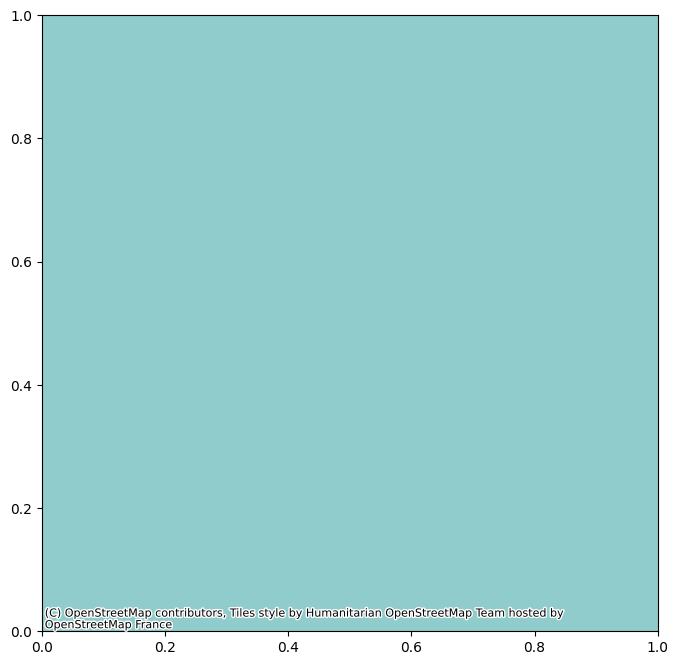

In [65]:
l4agdf_gsrm_epsg3857 = l4agdf_gsrm.to_crs(epsg=3857)
ax2=l4agdf_gsrm_epsg3857.plot(column='beam', legend=True, figsize=(10, 8))
ctx.add_basemap(ax2)

The above map shows the swath coverage of GEDI - a typical swath is ~4200m wide. GEDI instrument produces eight ground tracks plotted in the map with different colors. Let's zoom in into an area and look at the locations of actual shots.

In [ ]:
minx1, miny1, maxx1, maxy1 = [-9290000, 4237500, -9285500, 4242500]
ax3=l4agdf_gsrm_epsg3857.plot(column='beam', legend=True, figsize=(8, 10))
ax3.set_xlim(minx1, maxx1)
ax3.set_ylim(miny1, maxy1)
ctx.add_basemap(ax3)

# close the opened hdf5 file
hf.close()

The GEDI shots (or footprints) are separated by ~60 m along the track and ~600 m across the track. For more detailed look on GEDI L4A data, refer to [this tutorial on exploring GEDI L4A](3_gedi_l4a_exploring_data.ipynb).

### 4b. Subsetting all downloaded files

In the Steps 2 and 3 above, we downloaded L4A files into the directory `full_orbits`. We will now loop over each of these files and create a clipped version of the files into a new directory `subsets`. 

In [ ]:
indir = 'full_orbits'
outdir = 'subsets'

# converting to WGS84 coordinate system
grsm_epsg4326 = grsm_poly.to_crs(epsg=4326)

for infile in glob(path.join(indir, 'GEDI04_A*.h5')):
    name, ext = path.splitext(path.basename(infile))
    subfilename = "{name}_sub{ext}".format(name=name, ext=ext)
    outfile = path.join(outdir, path.basename(subfilename))
    hf_in = h5py.File(infile, 'r')
    hf_out = h5py.File(outfile, 'w')
    
    # copy ANCILLARY and METADATA groups
    var1 = ["/ANCILLARY", "/METADATA"]
    for v in var1:
        hf_in.copy(hf_in[v],hf_out)
    
    # loop through BEAMXXXX groups
    for v in list(hf_in.keys()):
        if v.startswith('BEAM'):
            beam = hf_in[v]
            # find the shots that overlays the area of interest (GRSM)
            lat = beam['lat_lowestmode'][:]
            lon = beam['lon_lowestmode'][:]
            i = np.arange(0, len(lat), 1) # index
            geo_arr = list(zip(lat,lon, i))
            l4adf = pd.DataFrame(geo_arr, columns=["lat_lowestmode", "lon_lowestmode", "i"])
            l4agdf = gpd.GeoDataFrame(l4adf, geometry=gpd.points_from_xy(l4adf.lon_lowestmode, l4adf.lat_lowestmode))
            l4agdf.crs = "EPSG:4326"
            l4agdf_gsrm = l4agdf[l4agdf['geometry'].within(grsm_epsg4326.geometry[0])]  
            indices = l4agdf_gsrm.i

            # copy BEAMS to the output file
            for key, value in beam.items():
                if isinstance(value, h5py.Group):
                    for key2, value2 in value.items():
                        group_path = value2.parent.name
                        group_id = hf_out.require_group(group_path)
                        dataset_path = group_path + '/' + key2
                        hf_out.create_dataset(dataset_path, data=value2[:][indices])
                        for attr in value2.attrs.keys():
                            hf_out[dataset_path].attrs[attr] = value2.attrs[attr]
                else:
                    group_path = value.parent.name
                    group_id = hf_out.require_group(group_path)
                    dataset_path = group_path + '/' + key
                    hf_out.create_dataset(dataset_path, data=value[:][indices])
                    for attr in value.attrs.keys():
                        hf_out[dataset_path].attrs[attr] = value.attrs[attr]

    hf_in.close()
    hf_out.close()

Now, new the subset files are created in the `subsets` directory. We will use the subset files to create a map of above ground biomass density (the variable `agbd` inside `BEAMXXXX` groups) of the GRSM. 

In [ ]:
testdir = '../subsets/1/'
lat_l = []
lon_l = []
agbd = []
outdir = 'subsets'
for subfile in glob(path.join(testdir, 'GEDI04_A*.h5')):
    hf_in = h5py.File(subfile, 'r')
    for v in list(hf_in.keys()):
        if v.startswith('BEAM'):
            beam = hf_in[v]
            lat_l.extend(beam['lat_lowestmode'][:].tolist()) 
            lon_l.extend(beam['lon_lowestmode'][:].tolist()) 
            agbd.extend(beam['agbd'][:].tolist())
    hf_in.close()
geo_arr = list(zip(agbd,lat_l,lon_l))
df = pd.DataFrame(geo_arr, columns=["agbd", "lat_lowestmode", "lon_lowestmode"])
gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.lon_lowestmode, df.lat_lowestmode))
gdf

In the above table, we see there are some shots with fill value (-9999). We will exclude these shots in the map below. The following is a map of aboveground biomass density (Mg/ha) or `agbd`.

In [ ]:
grsm_df = pd.DataFrame([[-9999,0,-9999,-9999,grsm_epsg4326.geometry.item()]], columns=["agbd", "l4_quality_flag","lat_lowestmode", "lon_lowestmode", "geometry"])
gdf = pd.concat([gdf, grsm_df])
gdf.crs="EPSG:4326"
gdf_epsg3857 = gdf.to_crs(epsg=3857)
ax4=gdf_epsg3857[-1:].plot(color='white', edgecolor='red', alpha=0.3, linewidth=5, figsize=(22, 7))
gdf_epsg3857[gdf_epsg3857['agbd'] != -9999][:-1].plot(ax=ax4, column='agbd', alpha=0.1, linewidth=0, legend=True)
ctx.add_basemap(ax4)

### 4c. Saving the subsets to different formats
In the step above, we created a HDF5 formatted output, which is the native format of GEDI L4A datasets. The HDF5 files can be output to `geojson` or `csv` or `ESRI Shapefile` using the geopandas.

In [ ]:
outdir = 'subsets'
subset_df = pd.DataFrame()
for subfile in glob(path.join(outdir, 'GEDI04_A*_sub.h5')):
    hf_in = h5py.File(subfile, 'r')
    for v in list(hf_in.keys()):
        if v.startswith('BEAM'):
            col_names = []
            col_val = []
            beam = hf_in[v]
            # copy BEAMS 
            for key, value in beam.items():
                # looping through subgroups
                if isinstance(value, h5py.Group):
                    for key2, value2 in value.items():
                        if (key2 != "shot_number"):
                             # xvar variables have 2D
                            if (key2.startswith('xvar')):
                                for r in range(4):
                                    col_names.append(key2 + '_' + str(r+1))
                                    col_val.append(value2[:, r].tolist())
                            else:
                                col_names.append(key2)
                                col_val.append(value2[:].tolist())
                
                #looping through base group
                else:
                    # xvar variables have 2D
                    if (key.startswith('xvar')):
                        for r in range(4):
                            col_names.append(key + '_' + str(r+1))
                            col_val.append(value[:, r].tolist())
                    else:
                        col_names.append(key)
                        col_val.append(value[:].tolist())
            
            # create a pandas dataframe        
            beam_df = pd.DataFrame(map(list, zip(*col_val)), columns=col_names) 
            # Inserting BEAM names
            beam_df.insert(0, 'BEAM', np.repeat(str(v), len(beam_df.index)).tolist())
            # Appending to the subset_df dataframe
            subset_df = pd.concat([subset_df, beam_df])

    hf_in.close()

Now, all the variables are stored in a pandas dataframe `subset_df`. We can print the dataframe.

In [ ]:
# Setting 'shot_number' as dataframe index. shot_number column is unique
subset_df = subset_df.set_index('shot_number') 
subset_df.head()

The dataframe has 204 columns representing GEDI L4A variables. We can export it to a **CSV** file directly as:

In [ ]:
subset_df.to_csv('subsets/grsm_subset.csv') # Export to CSV

If we want to save the file as one of the geospatial formats (such as GEOJSON, KML, ESRI Shapefile), we need to first convert the dataframe into a geopandas dataframe, and export to various formats.

In [ ]:
subset_gdf = gpd.GeoDataFrame(subset_df, geometry=gpd.points_from_xy(subset_df.lon_lowestmode, subset_df.lat_lowestmode))
subset_gdf.crs = "EPSG:4326"

# convert object types columns to strings. object types are not supported
for c in subset_gdf.columns:
    if subset_gdf[c].dtype == 'object':
        subset_gdf[c] = subset_gdf[c].astype(str)

# Export to GeoJSON
subset_gdf.to_file('subsets/grsm_subset.geojson', driver='GeoJSON')
# Export to ESRI Shapefile
subset_gdf.to_file('subsets/grsm_subset.shp')